# Diabetes EDA and ML Prep 

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases [(Source)](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

---

There are 9 columns
* Pregnancies - Number of times pregnant
* Glucose - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure - Diastolic blood pressure (mm Hg)
* SkinThickness - Triceps skin fold thickness (mm)
* Insulin - 2-Hour serum insulin (mu U/ml)
* BMI - Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction - Diabetes pedigree function, a function which scores likelihood of diabetes based on family history
* Age (years)
* Outcome - Class variable (0 or 1) 268 of 768 are 1, the others are 0  

---

In [1]:
%load_ext lab_black

In [2]:
# Data Wrangling
import numpy as np
import pandas as pd

# Data processing, metrics and modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warning messages
import warnings

warnings.filterwarnings("ignore")

In [3]:
def get_train_test(df):
    return train_test_split(
        df.loc[:, df.columns != "Outcome"],
        df["Outcome"],
        test_size=0.3,
        random_state=77,
    )


def score_data(scored_df_):
    X_train, X_test, y_train, y_test = get_train_test(scored_df_)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return confusion_matrix(y_test, predictions, labels=model.classes_)

In [4]:
diabetes_df = pd.read_csv("data/diabetes.csv")
diabetes_cm = score_data(diabetes_df)

## Baseline Model

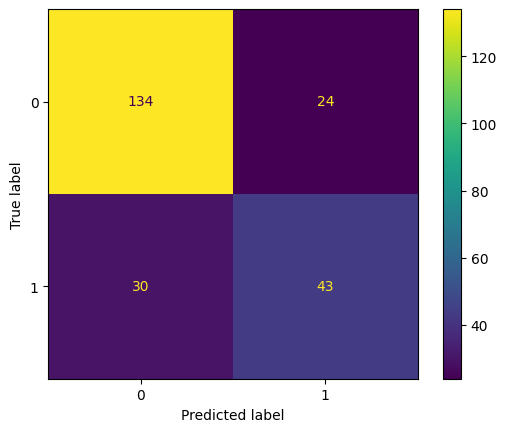

In [5]:
disp = ConfusionMatrixDisplay(diabetes_cm)
disp.plot()

Our baseline model score is as follows:

In [6]:
# True positive, false positive, true negative, false negative
tp = diabetes_cm[1, 1]
fp = diabetes_cm[0, 1]
tn = diabetes_cm[0, 0]
fn = diabetes_cm[1, 0]

# Calculating Scores
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)  # also, sensitivity
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.77
Precision: 0.64
Recall (Sensitivity): 0.59
Specificity: 0.85
F1 Score: 0.61


We can interpret the metrics of the baseline logistic regression model as follows:

1. Accuracy (0.77):
   - Ratio of correctly predicted instances to the total instances
   - Here, it only correctly predicts diabetes 77% of the time.
   - Such accuracy is inferior in a medical context.
   - Furthermore, accuracy alone doesn't tell us the whole story: perhaps the dataset is imbalanced.
2. Precision (0.64):
   - Ratio of true positive predictions (correctly predicted diabetes cases) to all positive predictions (both true positives and false positives)
   - Here, when the model predicts diabetes, it's correct only 64% of the time–very poor in a model context.
3. Recall/Sensitivity (0.59):
   - Ratio of true positive predictions to all actual positive instances.
   - A lower recall implies that the model misses a significant portion of true diabetes cases.
4. Specificity (0.85):
   - Ratio of true negative predictions (correctly predicted non-diabetes cases) to all actual negative instances.
   - In comparison to the previous metrics, 0.85 is a decent specificity. However, it again still falls short of what might be required in a medical domain.
   - A high specificity helps avoid false alarms (predicting diabetes when there are none) as it could potentially lead to a misdiagnosis.
5. F1 Score (0.61):
   - Harmonic mean of precision and recall, balancing the trade-off between false positives and false negatives
   - A low F1 score signifies that the model is overall poor.

In [7]:
diabetes_df.shape

(768, 9)

**Preliminary Assumptions**:

* Each row in the dataset represents a unique patient rather than multiple observations from the same patient.
    * Violating this assumption can lead to biased parameter estimates and incorrect statistical inferences.
    * Given the de-identified nature of the data, it's challenging to verify the uniqueness of each patient across rows.
* The dataset is assumed to be a representative sample of the population: females over 21 years old of Pima Indian heritage who have undergone diabetes testing.
    * However, the assumption of representativeness could be compromised if the model's performance in production deviates from expectations.
    * Potentially indicating a mismatch between the dataset's distribution and the actual population.

## Univariate Analysis - What does each variable signify?

### Pregnancies

* The "Pregnancies" variable represents the times a patient has experienced pregnancy up to the age recorded in the dataset.
* It's worth noting that this count doesn't necessarily equate to the number of childbirths or provide insight into how the pregnancy data was documented.
* The recorded pregnancies could be self-reported by patients, and the accuracy of this data is challenging to verify.
* Lastly, the significance of this variable lies in its connection to the relationship between pregnancies and diabetes, particularly gestational diabetes, which is influenced by the natural hormonal changes and increased insulin resistance that occur during pregnancy [1].

In [8]:
diabetes_df["Pregnancies"].isna().sum()

0

* Pregnancies have **no missing values.**
* Even if we found missing values for pregnancies, we would replace them with '0', i.e., no pregnancies.

In [9]:
diabetes_df["Pregnancies"].describe()

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64

We suspect some outliers here–there exist instances where patients have reported up to 17 pregnancies.

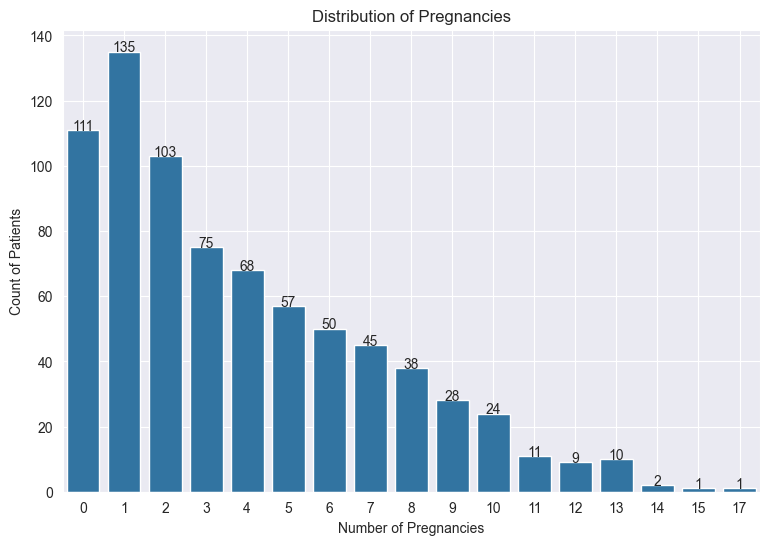

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
ax = sns.countplot(x="Pregnancies", data=diabetes_df)
plt.xlabel("Number of Pregnancies")
plt.ylabel("Count of Patients")
plt.title("Distribution of Pregnancies")
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="baseline",
    )
plt.grid(True)
plt.show()

* The plot above shows that instances with exceptionally high pregnancies are limited in number.
* Since there's no domain knowledge on the permissible range of pregnancies, we'll use the Interquartile Range (IQR) to identify these outliers and view specific data points.
* The above plot also shows that our data is skewed to the right, with most instances close to 0-2.
* Although number of pregnancies is a categorical variable, a higher number of pregnancies could indicate the onset of diabetes. Hence, we'll need to preserve its ordinal properties and treat it as a numerical value for our logistic regression model.

In [11]:
Q1 = diabetes_df["Pregnancies"].quantile(0.25)
Q3 = diabetes_df["Pregnancies"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(
    f"Lower Bound of Pregnancies: {lower_bound}\nUpper Bound of Pregnancies: {upper_bound}"
)

Lower Bound of Pregnancies: -6.5
Upper Bound of Pregnancies: 13.5


In [12]:
# Only upper bound, since the lowest number of pregnancies are zero
diabetes_df[diabetes_df["Pregnancies"] > upper_bound]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
88,15,136,70,32,110,37.1,0.153,43,1
159,17,163,72,41,114,40.9,0.817,47,1
298,14,100,78,25,184,36.6,0.412,46,1
455,14,175,62,30,0,33.6,0.212,38,1


* It's interesting to note how all the outliers, albeit only four data points, correspond to instances of diabetes. While this might indicate potential cases of gestational diabetes, we cannot verify this. 
* Although extreme, given the patient's age, it is possible to get pregnant multiple times.
* Hence, we wouldn't be dropping this from our dataset–4 of 768 constitute only 0.5% of the population, so this won't skew our model.

Let's also look at pregnancies by age (or rate of pregnancy) as a means to weed out outliers:

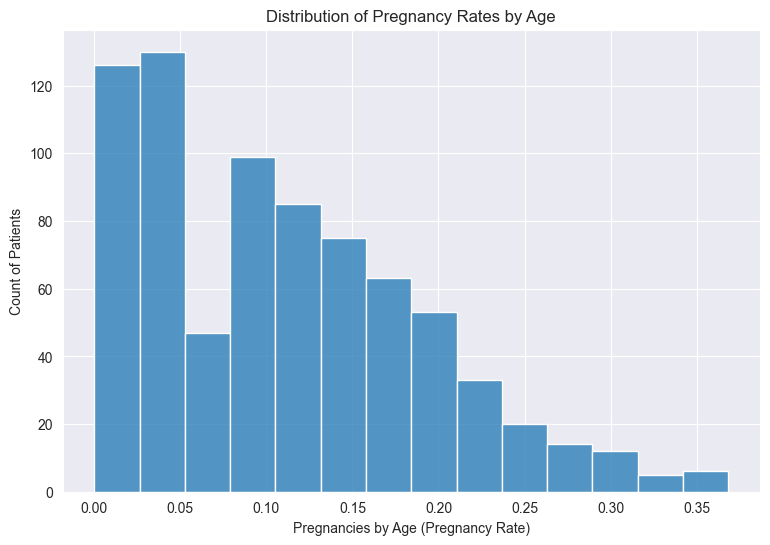

In [13]:
diabetes_df["PregnanciesByAge"] = diabetes_df["Pregnancies"] / diabetes_df["Age"]

sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.histplot(data=diabetes_df, x="PregnanciesByAge", kde=False)
plt.xlabel("Pregnancies by Age (Pregnancy Rate)")
plt.title("Distribution of Pregnancy Rates by Age")
plt.ylabel("Count of Patients")
plt.grid(True)
plt.show()

The distribution looks fairly similar, however, we see fewer outliers in this case. We'll use IQR again to identify these outliers.

In [14]:
Q1 = diabetes_df["PregnanciesByAge"].quantile(0.25)
Q3 = diabetes_df["PregnanciesByAge"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(
    f"Lower Bound of Pregnancy Rate: {lower_bound}\nUpper Bound of Pregnancy Rate: {upper_bound}"
)

Lower Bound of Pregnancy Rate: -0.14583333333333334
Upper Bound of Pregnancy Rate: 0.35416666666666663


In [15]:
diabetes_df[diabetes_df["PregnanciesByAge"] > upper_bound]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,PregnanciesByAge
159,17,163,72,41,114,40.9,0.817,47,1,0.361702
455,14,175,62,30,0,33.6,0.212,38,1,0.368421
731,8,120,86,0,0,28.4,0.259,22,1,0.363636


* Similar to the case above, we can see that the outliers are the patients with diabetes.
* Eight pregnancies at the age of 22 seems suspiciously high.
    * After looking into Patient 731's profile, we can see that their `SkinThickness` and `Insulin` are morbidly low.
    * We will investigate this later and check if the features can be use to identify outliers.
* However, it is unlikely to use `PregnanciesByAge` or `Pregnancies` to drop outliers.

In [16]:
diabetes_df.drop(["PregnanciesByAge"], axis=1, inplace=True)

### Glucose

* Glucose refers to plasma glucose concentration for 2 hours in an Oral Glucose Tolerance Test (OGTT).
    * We'll assume that the test was conducted correctly in most instances.
    * This includes abiding by testing guidelines such as fasting for at least hours before the test.
* It should be noted that a single test alone cannot confirm a diagnosis [2].
* Hence, we might see a correlation with the `Outcome` variable when performing a bivariate analysis; however, this test alone shouldn't be used to confirm diabetes.

In [17]:
diabetes_df["Glucose"].describe()

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

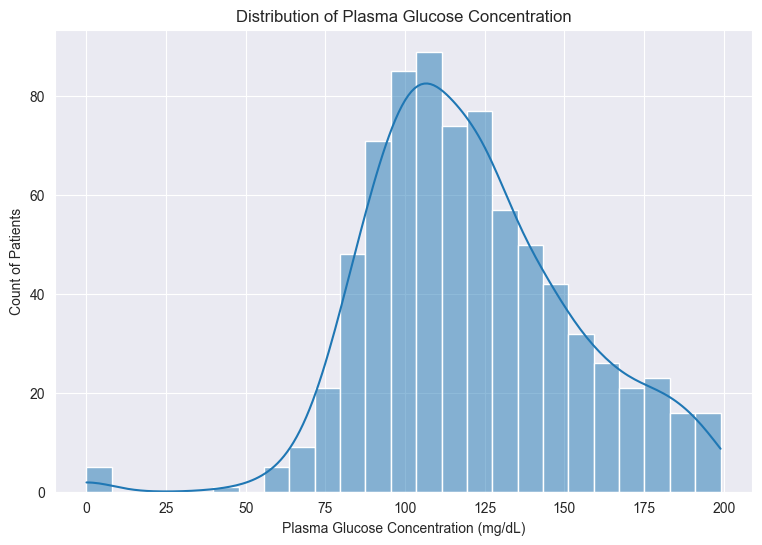

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.histplot(data=diabetes_df, x="Glucose", kde=True, bins=25)
plt.xlabel("Plasma Glucose Concentration (mg/dL)")
plt.ylabel("Count of Patients")
plt.title("Distribution of Plasma Glucose Concentration")
plt.grid(True)
plt.show()

* According to the CDC [3],
    * \>=200 mg/dL = Diabetes
    * 140 - 199 mg/dL = Prediabetes
    * <140 mg/dL = Normal
* Since this data is distributed around a mean of 120, we're assuming the glucose measure is in mg/dL and not mmol/L. Furthermore, a thicker tail around the higher value suggests our data could be biased toward high-blood glucose patients.
* Although we're not seeing any issues with our upper bound, we can see suspiciously low values. The lowest is 0, which seems physiologically possible in a living human being.
* According to an NCBI article [4], plasma glucose lower than 20 mg/dL corresponds to brain death. Furthermore, coma can occur at levels 41-49 mg/dL.
* Rather than using IQR to estimate outliers, we'll use a lower bound of 60 mg/dL based on domain knowledge and an upper bound of 3000 mg/dL (The highest recorded is 2656 mg/dL).

In [19]:
glucose_lower_bound = 60
glucose_upper_bound = 3000

diabetes_df.loc[
    (diabetes_df["Glucose"] > glucose_upper_bound)
    | (diabetes_df["Glucose"] < glucose_lower_bound),
]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
62,5,44,62,0,0,25.0,0.587,36,0
75,1,0,48,20,0,24.7,0.140,22,0
146,9,57,80,37,0,32.8,0.096,41,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1
537,0,57,60,0,0,21.7,0.735,67,0
680,2,56,56,28,45,24.2,0.332,22,0


* It's interesting to note how the patients that are below our glucose threshold have corresponding anomalous values for other factors such as 0 Insulin.
* Furthermore, according to our plot, there is a notable spike in values at the lower end of the glucose distribution, possibly indicating the presence of missing or improperly recorded data points.
* We can thereby treat any values below and above this threshold as improperly recorded and impute them.

Let's also check if patients with >= 200 mg/dL are diabetic according to our dataset. We'll use 190 in our case as we don't have data above 200 mg/dL.

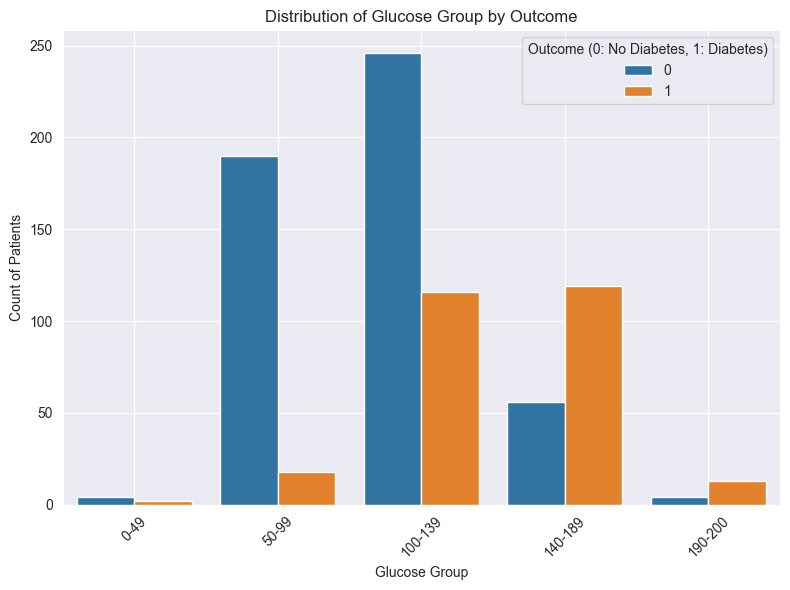

In [20]:
bin_edges = [0, 50, 100, 140, 190, 200]
bin_labels = ["0-49", "50-99", "100-139", "140-189", "190-200"]
diabetes_df["GlucoseGroup"] = pd.cut(
    diabetes_df["Glucose"], bins=bin_edges, labels=bin_labels, include_lowest=True
)
plt.figure(figsize=(8, 6))
sns.countplot(x="GlucoseGroup", hue="Outcome", data=diabetes_df)
plt.xlabel("Glucose Group")
plt.ylabel("Count of Patients")
plt.title("Distribution of Glucose Group by Outcome")
plt.xticks(rotation=45)
plt.legend(title="Outcome (0: No Diabetes, 1: Diabetes)")
plt.tight_layout()
plt.grid(True)
plt.show()

In [21]:
diabetes_df.drop(["GlucoseGroup"], axis=1, inplace=True)

* Although patients are more likely to have diabetes at levels over 190, we can't see a strong trend in our dataset. 
* Only 70% of 18 patients are confirmed diabetics. There must be other factors at play here.

### BloodPressure

* Blood Pressure or Diastolic Blood Pressure (mm/Hg) measures the pressure in the arteries when the heart is at rest or between heartbeats.
* Elevated diastolic blood pressure is linked with an increased risk of cardiovascular complications in individuals with diabetes.
* It's important to clarify that while high diastolic blood pressure can be a consequence of diabetes, it is not a root cause of diabetes. Abnormally high diastolic blood pressure may indicate diabetes risk, but it does not necessarily confirm the onset of the condition.

In [22]:
diabetes_df["BloodPressure"].describe()

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

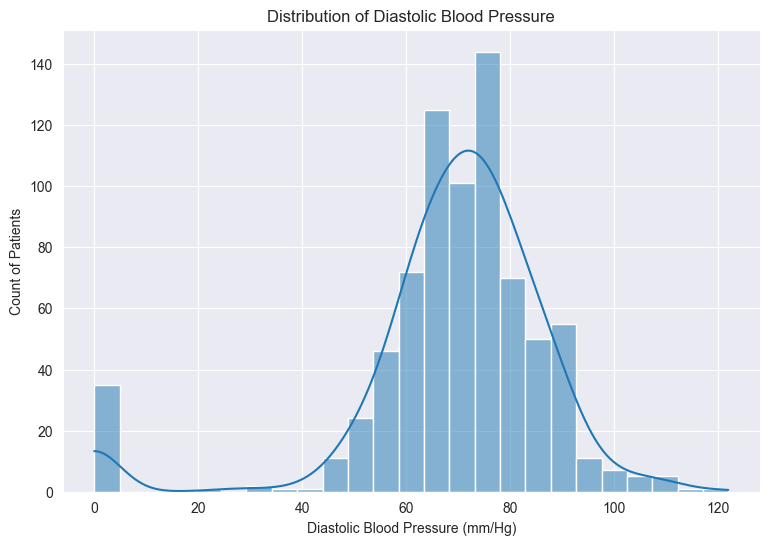

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.histplot(data=diabetes_df, x="BloodPressure", kde=True, bins=25)
plt.xlabel("Diastolic Blood Pressure (mm/Hg)")
plt.ylabel("Count of Patients")
plt.title("Distribution of Diastolic Blood Pressure")
plt.grid(True)
plt.show()

* Similar to `Glucose`, we see a spike in the values around 0 – we'll treat these as missing values.
* Diastolic blood pressure is typically observed as [6]:
    * < 80 mm/Hg = Normal
    * 80-89 mm/Hg = High Blood Pressure - Hypertension Stage 1
    * 90-120 mm/Hg = High Blood Pressure - Hypertension Stage 2
    * \> 120 mm/Hg = Hypertensive Crisis
* We'll keep our upper bound as 250 mm/Hg, Given the highest recorded reading was 284 mm/Hg [7] and our data has a maximum of 120 mg/Hg.
* We'll assume 30 mm/Hg as our lower bound as Hypotension is around 60 mm/Hg.

In [24]:
bp_lower_bound = 30
bp_upper_bound = 250

diabetes_df.loc[
    (
        (diabetes_df["BloodPressure"] > bp_upper_bound)
        | (diabetes_df["BloodPressure"] < bp_lower_bound)
    )
    & (diabetes_df["BloodPressure"] != 0),
]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
597,1,89,24,19,25,27.8,0.559,21,0


Apart from the ~35 0 values for BloodPressure, we see one instance with an abnormally low blood pressure which we can impute. 

### SkinThickness

* SkinThickness or Triceps skin fold thickness (mm) is a measure of subcutaneous fat.
* Although, SkinThickness isn't a direct measure of diabetes, it can be related to it through other ways such as Obesity.
* When coupled with BMI, SkinThickness acts as another measure for Obesity, which is a well-established risk factor for type-2 diabetes.

In [25]:
diabetes_df["SkinThickness"].describe()

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64

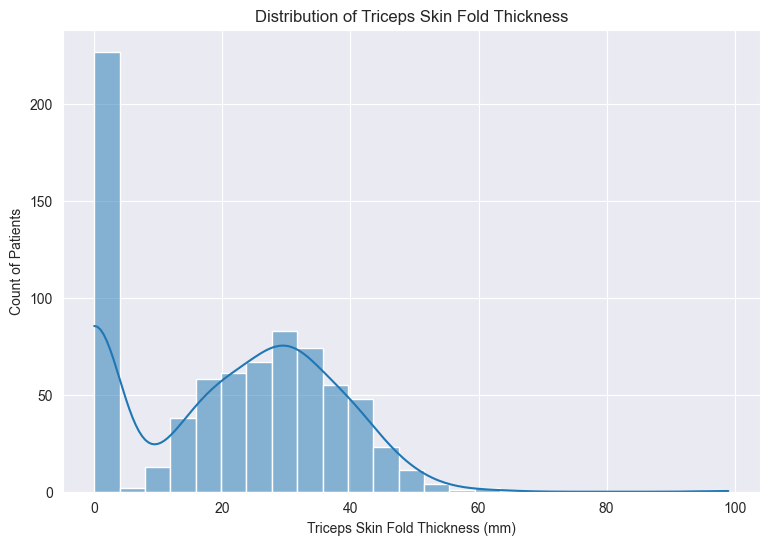

In [26]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.histplot(data=diabetes_df, x="SkinThickness", kde=True, bins=25)
plt.xlabel("Triceps Skin Fold Thickness (mm)")
plt.ylabel("Count of Patients")
plt.title("Distribution of Triceps Skin Fold Thickness")
plt.grid(True)
plt.show()

* Similar to previous instances, 0 Triceps Skin Fold Thickness constitutes missing values.
* So we can assume some of these patients didn't get their skin thickness checked.
* It is important to note that there are over 250 instances with missing skin thickness, which is roughly 30% of our data – significant number of data points to impute.
* Since BMI, skin thickness, and obesity are correlated, missing skin thickness should corroborated with BMI.

### Insulin

* Insulin or 2-hour Serum Insulin (mu U/ml) is related to diabetes risk, insulin resistance, and metabolic conditions that increase the likelihood of developing type 2 diabetes.
* Insulin measurements are often used in clinical settings to assess insulin resistance, beta cell function, and diabetes risk.

In [27]:
diabetes_df["Insulin"].describe()

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

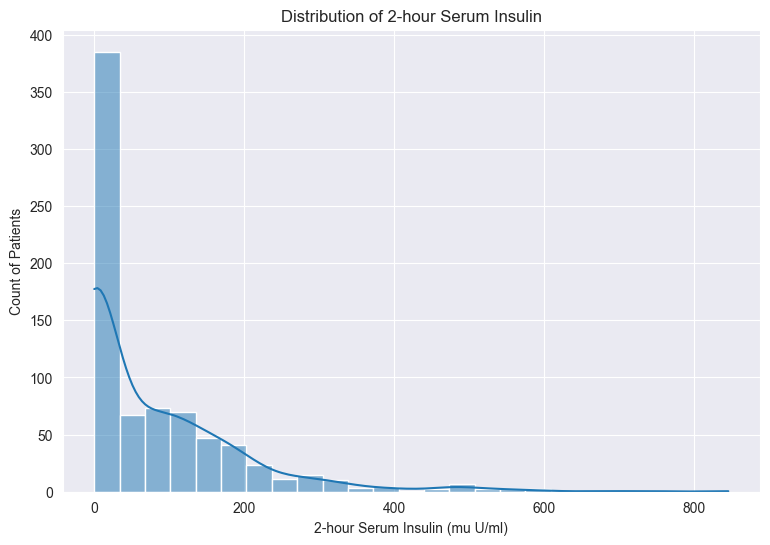

In [28]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.histplot(data=diabetes_df, x="Insulin", kde=True, bins=25)
plt.xlabel("2-hour Serum Insulin (mu U/ml)")
plt.ylabel("Count of Patients")
plt.title("Distribution of 2-hour Serum Insulin")
plt.grid(True)
plt.show()

* We see a similar trend with zeros here, suggesting we might need to impute them.
* However, according to a Pubmed article [8], an insulin level of zero is theoretically possible.
* The article's objective is to "determine the meaning of $S(i) = 0$ derived from the frequently sampled intravenous glucose tolerance test," implying that 0 is an observed value.
* The study further suggests having $S(i) = 0$ is indicative of significant insulin resistance.
    * It is not a program error or an anomaly but rather a reflection of the fact that individuals with diabetes often exhibit profound insulin resistance, resulting in $S(i)$ values of zero.
    * Finding $S(i) = 0$ with the 2-hour test for diabetic patients is statistically significant and is associated with a greater degree of insulin resistance and cardiovascular risk factors, especially in the type 2 diabetes group.
* Therefore, we shouldn't be imputing these values; a long-tailed left-skewed distribution makes sense.


Verifying if 0 is a missing value:
* Let's verify this using our outcome variable - do 0 insulin correspond to 0 insulin?
* Given that insulin is 0, does it carry a higher risk of diabetes?

In [29]:
bin_edges = [0, 5, 11, 50, 100, 150, 200, 250, 300, 600, 800, 1000]
bin_labels = [
    "0-4",
    "5-10",
    "11-49",
    "50-99",
    "100-149",
    "150-199",
    "200-249",
    "250-299",
    "300-599",
    "600-799",
    "800-1000",
]
diabetes_df["InsulinGroup"] = pd.cut(
    diabetes_df["Insulin"], bins=bin_edges, labels=bin_labels, include_lowest=True
)

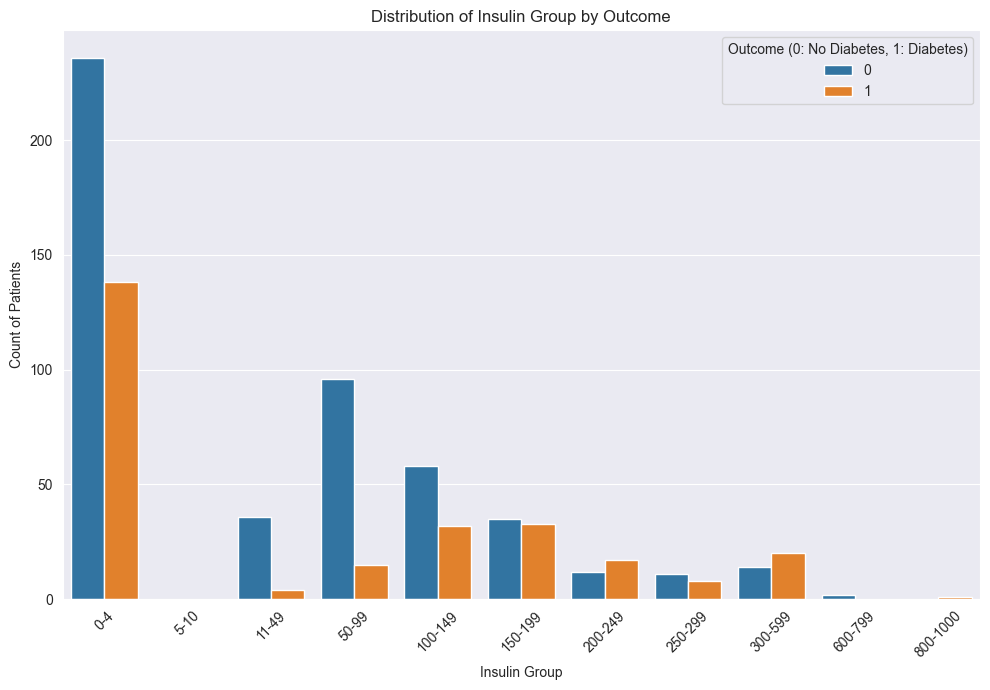

In [30]:
plt.figure(figsize=(10, 7))
sns.countplot(x="InsulinGroup", hue="Outcome", data=diabetes_df)
plt.xlabel("Insulin Group")
plt.ylabel("Count of Patients")
plt.title("Distribution of Insulin Group by Outcome")
plt.xticks(rotation=45)
plt.legend(title="Outcome (0: No Diabetes, 1: Diabetes)")
plt.tight_layout()
plt.show()

In [31]:
diabetes_df.drop(["InsulinGroup"], axis=1, inplace=True)

* Based on the 0-4 range, given the low insulin levels, the prominence of diabetes should be high.
* However, this isn't the case we our data as the number of positive cases of diabetes are lower for almost 0 insulin levels.
* Hence, these are more likely to be missing values as opposed to '0' insulin cases.

### BMI

* BMI or Body Mass Index (weight in kg/(height in m)^2) indicates a person's overall body fat.
* Although people with higher BMIs are at a greater risk of developing diabetes,
    * BMI as a standalone parameter isn't sufficient.
    * One such reason is because it doesn't distinguish between fat and muscle, which is where other parameters such as SkinThickness would be helpful.

In [32]:
diabetes_df["BMI"].describe()

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

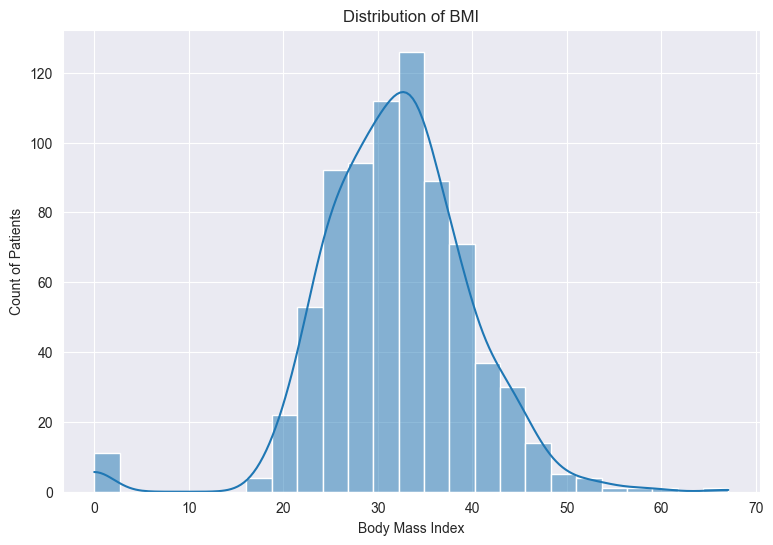

In [33]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.histplot(data=diabetes_df, x="BMI", kde=True, bins=25)
plt.xlabel("Body Mass Index")
plt.ylabel("Count of Patients")
plt.title("Distribution of BMI")
plt.grid(True)
plt.show()

* Our BMI graph almost resembles a normal distribution, making it an ideal parameter for logistic regression.
* However, BMIs of 0s are impossible and hence might be missing values, which we will impute going forward.

### DiabetesPedigreeFunction

* Diabetes pedigree function is a function that scores the likelihood of diabetes based on family history.
* According to the American Diabetes Association (ADA) [9], diabetes can have a hereditary component, especially for Type-2 diabetes.

In [34]:
diabetes_df["DiabetesPedigreeFunction"].describe()

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

In [35]:
diabetes_df["DiabetesPedigreeFunction"].isna().sum()

0

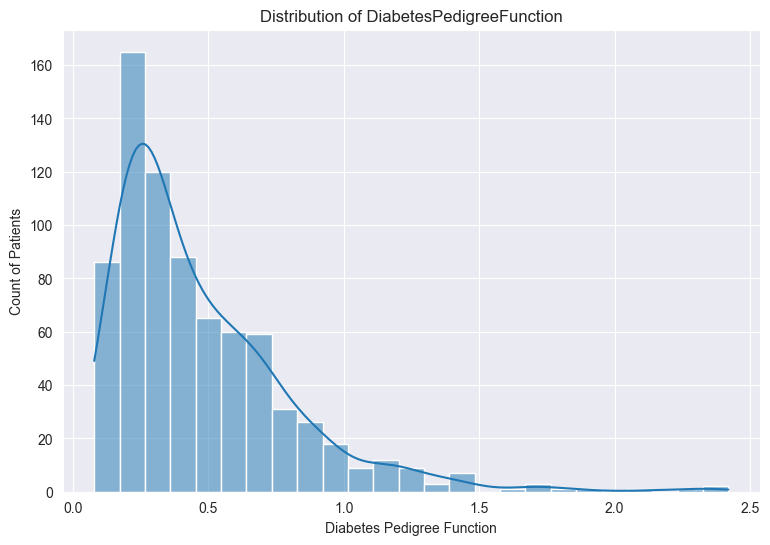

In [36]:
sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
sns.histplot(data=diabetes_df, x="DiabetesPedigreeFunction", kde=True, bins=25)
plt.xlabel("Diabetes Pedigree Function")
plt.ylabel("Count of Patients")
plt.title("Distribution of DiabetesPedigreeFunction")
plt.grid(True)
plt.show()

* `DiabetesPedigreeFunction` follows a right-skewed distribution with a mean at 0.47.
* Based on the given data, there don't seem to be any missing values.

### Age

According to the ADA, "older adults are at high risk for developing type 2 diabetes due to the combined effects of increasing insulin resistance and impaired pancreatic islet function with aging" [10].

In [37]:
diabetes_df["Age"].describe()

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [38]:
diabetes_df["Age"].isna().sum()

0

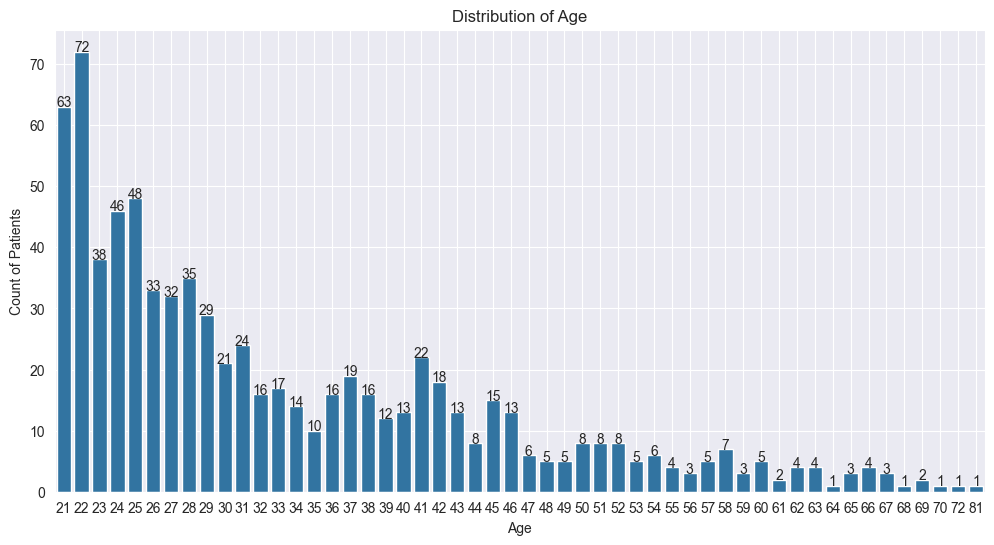

In [39]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="Age", data=diabetes_df.sort_values(by="Age"))
plt.xlabel("Age")
plt.ylabel("Count of Patients")
plt.title("Distribution of Age")
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="baseline",
    )
plt.grid(True)
plt.show()

* Age doesn't have any missing values nor does it seem to have any outliers.
* However, most of the data seem to be under the age of 40 (~75%) -- the data seems to be biased towards a younger patients.

### Outcome - is there class-imbalance?

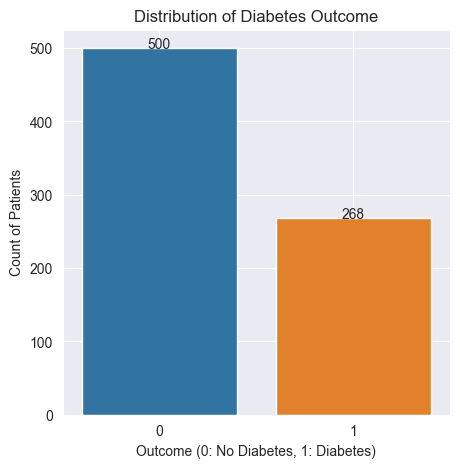

In [40]:
sns.set_style("darkgrid")
plt.figure(figsize=(5, 5))
ax = sns.countplot(x="Outcome", data=diabetes_df, hue="Outcome", legend=False)
plt.xlabel("Outcome (0: No Diabetes, 1: Diabetes)")
plt.ylabel("Count of Patients")
plt.title("Distribution of Diabetes Outcome")
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="baseline",
    )
plt.grid(True)
plt.show()

* Based on the distribution, there seems to be a fair imbalance between No Diabetes and Diabetes.
* However, according to a study published in the ADA [11], 46.8% of women of full Pima heritage had diabetes.
* This suggests that our data might be representative of the population.
* We might bootstrap data if our logistic regression model is unable to converge.

## Treating Missing Data

According to our univariate analysis, the following columns had missing values:
1. Glucose $\rightarrow$ 0s and some instances below 60 mg/dL
2. BloodPressure $\rightarrow$ 0s and some instances below 30 mm/Hg
3. SkinThickness $\rightarrow$ 0s
4. Insulin $\rightarrow$ 0s
5. BMI $\rightarrow$ 0s

In [41]:
selected_missing_columns = [
    "BloodPressure",
    "Glucose",
    "SkinThickness",
    "Insulin",
    "BMI",
]

# Bounds from univariate analysis
glucose_lower_bound = 60
glucose_upper_bound = 3000
bp_lower_bound = 30
bp_upper_bound = 250

### Missing Variable vs Outcome

How are the outcome values distributed for data points that are missing?

In [42]:
# Masks for missing values
glucose_mask = (diabetes_df["Glucose"] < glucose_lower_bound) | (
    diabetes_df["Glucose"] > glucose_upper_bound
)
bp_mask = (diabetes_df["BloodPressure"] < bp_lower_bound) | (
    diabetes_df["BloodPressure"] > bp_upper_bound
)
skin_thickness_mask = diabetes_df["SkinThickness"] == 0
insulin_mask = diabetes_df["Insulin"] == 0
bmi_mask = diabetes_df["BMI"] == 0

data_masks = [bp_mask, glucose_mask, skin_thickness_mask, insulin_mask, bmi_mask]

outcome_proportions_df = pd.DataFrame()

# Iterate over each missing variable and find proportions
for mask, column in zip(data_masks, selected_missing_columns):
    total_count = len(diabetes_df.loc[mask])
    outcome_0_count = len(diabetes_df.loc[mask & (diabetes_df["Outcome"] == 0)])
    outcome_1_count = len(diabetes_df.loc[mask & (diabetes_df["Outcome"] == 1)])

    outcome_proportions_df = pd.concat(
        [
            outcome_proportions_df,
            pd.DataFrame(
                {
                    "Feature": column,
                    "Non-Diabetes (Count)": outcome_0_count,
                    "Non-Diabetes (Prop)": outcome_0_count / total_count,
                    "Diabetes (Count)": outcome_1_count,
                    "Diabetes (Prop)": outcome_1_count / total_count,
                },
                index=[0],
            ),
        ],
        ignore_index=True,
    )

outcome_proportions_df = pd.concat(
    [
        outcome_proportions_df,
        pd.DataFrame(
            {
                "Feature": "Overall",
                "Non-Diabetes (Count)": (diabetes_df["Outcome"] == 0).sum(),
                "Non-Diabetes (Prop)": (diabetes_df["Outcome"] == 0).sum()
                / diabetes_df.shape[0],
                "Diabetes (Count)": (diabetes_df["Outcome"] == 1).sum(),
                "Diabetes (Prop)": (diabetes_df["Outcome"] == 1).sum()
                / diabetes_df.shape[0],
            },
            index=[0],
        ),
    ],
    ignore_index=True,
)

In [43]:
outcome_proportions_df

,Feature,Non-Diabetes (Count),Non-Diabetes (Prop),Diabetes (Count),Diabetes (Prop)
0,BloodPressure,20,0.555556,16,0.444444
1,Glucose,7,0.777778,2,0.222222
2,SkinThickness,139,0.612335,88,0.387665
3,Insulin,236,0.631016,138,0.368984
4,BMI,9,0.818182,2,0.181818
5,Overall,500,0.651042,268,0.348958


* The above proportions display how the Outcome variable is split across rows where each feature has missing values. E.g.,
    * For `BloodPressure` we filter for missing values and calculate the proportion of those with and without Diabetes. 
    * `Insulin` follows a distribution akin to the population. As stated earlier, this shouldn't be the case for 0 insulin – our data should be heavily skewed towards diabetic patients.
* Based on the proportions above, it is evident that the missing values share no relationship with the outcome variable for those variables with sufficient data).
* Their distribution is consistent with the population. Therefore, imputing their data should not introduce any bias.

### Strategy Selection

* Should we use KNNs or Means to impute missing values?
* Intuitively, KNNs should be better suited for imputing a patient's missing data.
* When using a mean, we assume that when a patient doesn't submit their readings, it is most likely to resemble an expected value - which isn't the case.
* The missing values should most closely resemble those of similar patients.

In [44]:
# Masks for missing values
glucose_mask = (diabetes_df["Glucose"] > glucose_lower_bound) & (
    diabetes_df["Glucose"] < glucose_upper_bound
)
bp_mask = (diabetes_df["BloodPressure"] > bp_lower_bound) & (
    diabetes_df["BloodPressure"] < bp_upper_bound
)
skin_thickness_mask = diabetes_df["SkinThickness"] > 0
insulin_mask = diabetes_df["Insulin"] > 0
bmi_mask = diabetes_df["BMI"] > 0

non_missing_diabetes_df = diabetes_df.loc[
    (glucose_mask & bp_mask & skin_thickness_mask & insulin_mask & bmi_mask), :
]

In [45]:
# Evaluating KNNs vs Mean-imputatation for each parameter
missing_model_evals = []

for column in selected_missing_columns:
    X = non_missing_diabetes_df.drop(columns=["Outcome", column])
    y = non_missing_diabetes_df[column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)

    mean_model = np.mean(y_train)

    knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mean_rmse = np.sqrt(mean_squared_error(y_test, np.full_like(y_test, mean_model)))

    missing_model_evals.append(
        pd.DataFrame(
            {"Feature": column, "KNN RMSE": knn_rmse, "Mean-Model RMSE": mean_rmse},
            index=[0],
        )
    )

pd.concat(missing_model_evals, ignore_index=True)

,Feature,KNN RMSE,Mean-Model RMSE
0,BloodPressure,11.644984,12.947626
1,Glucose,20.722353,29.242356
2,SkinThickness,10.197084,10.198039
3,Insulin,116.179402,128.473234
4,BMI,6.748185,7.065904


* Accross all variables, a KNN outperforms a simple Mean-Model to replace missing values.
* We'll use a `KNNImputer` to fill missing values in our diabetes dataset (given that the underlying algorithm is the same).

In [46]:
filled_missing_diabetes_df = diabetes_df.copy()

filled_missing_diabetes_df.loc[
    (filled_missing_diabetes_df["Glucose"] < glucose_lower_bound)
    | (filled_missing_diabetes_df["Glucose"] > glucose_upper_bound),
    "Glucose",
] = np.nan

filled_missing_diabetes_df.loc[
    (filled_missing_diabetes_df["BloodPressure"] < bp_lower_bound)
    | (filled_missing_diabetes_df["BloodPressure"] > bp_upper_bound),
    "BloodPressure",
] = np.nan
filled_missing_diabetes_df.loc[
    filled_missing_diabetes_df["SkinThickness"] == 0, "SkinThickness"
] = np.nan
filled_missing_diabetes_df.loc[
    filled_missing_diabetes_df["Insulin"] == 0, "Insulin"
] = np.nan
filled_missing_diabetes_df.loc[filled_missing_diabetes_df["BMI"] == 0, "BMI"] = np.nan

In [47]:
features_df = filled_missing_diabetes_df.drop("Outcome", axis=1)
imputer = KNNImputer(n_neighbors=5)
features_df_imputed = imputer.fit_transform(features_df)
imputed_filled_missing_diabetes_df = pd.DataFrame(
    features_df_imputed, columns=features_df.columns
)
imputed_filled_missing_diabetes_df["Outcome"] = filled_missing_diabetes_df["Outcome"]

### Comparing Distributions

Checking the distribution of these columns before and after imputation.

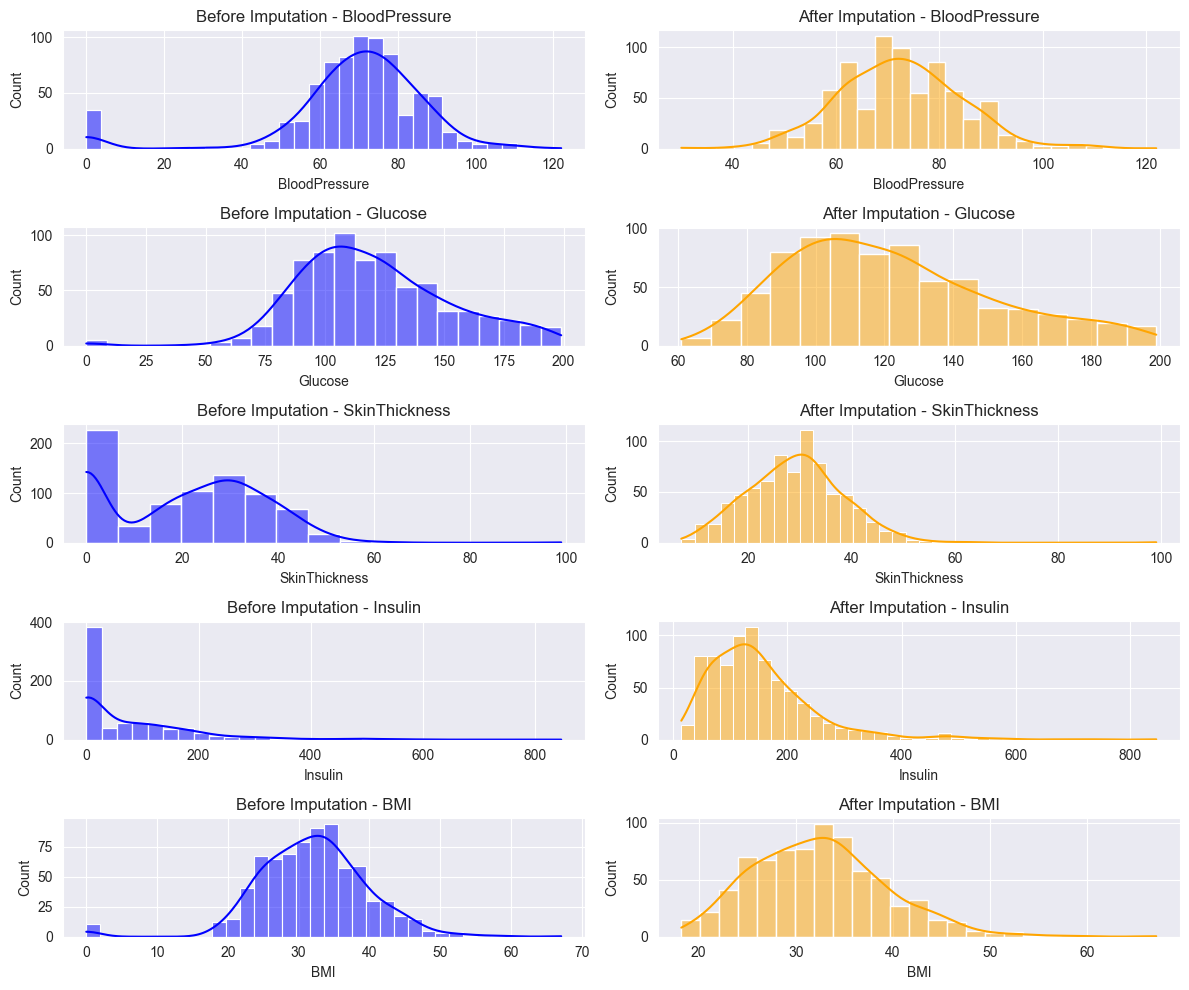

In [48]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=len(selected_missing_columns), ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(selected_missing_columns):
    sns.histplot(data=diabetes_df, x=column, kde=True, ax=axes[i, 0], color="blue")
    axes[i, 0].set_title(f"Before Imputation - {column}")
    sns.histplot(
        data=imputed_filled_missing_diabetes_df,
        x=column,
        kde=True,
        ax=axes[i, 1],
        color="orange",
    )
    axes[i, 1].set_title(f"After Imputation - {column}")

plt.tight_layout()
plt.show()

* Based on the above graphs, we can see that each distribution exhibits characteristics reminiscent of a bell curve.
* This bell-shaped pattern suggests that our data is inclined towards a more Gaussian distribution, a valuable trait for convergence when employing Logistic Regression.
* Furthermore, it also implies that haven't added any bias in our dataset.

## Feature vs Targets

Analyzing how each feature variable compares with the outcome variable.

In [49]:
subset_columns = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
]

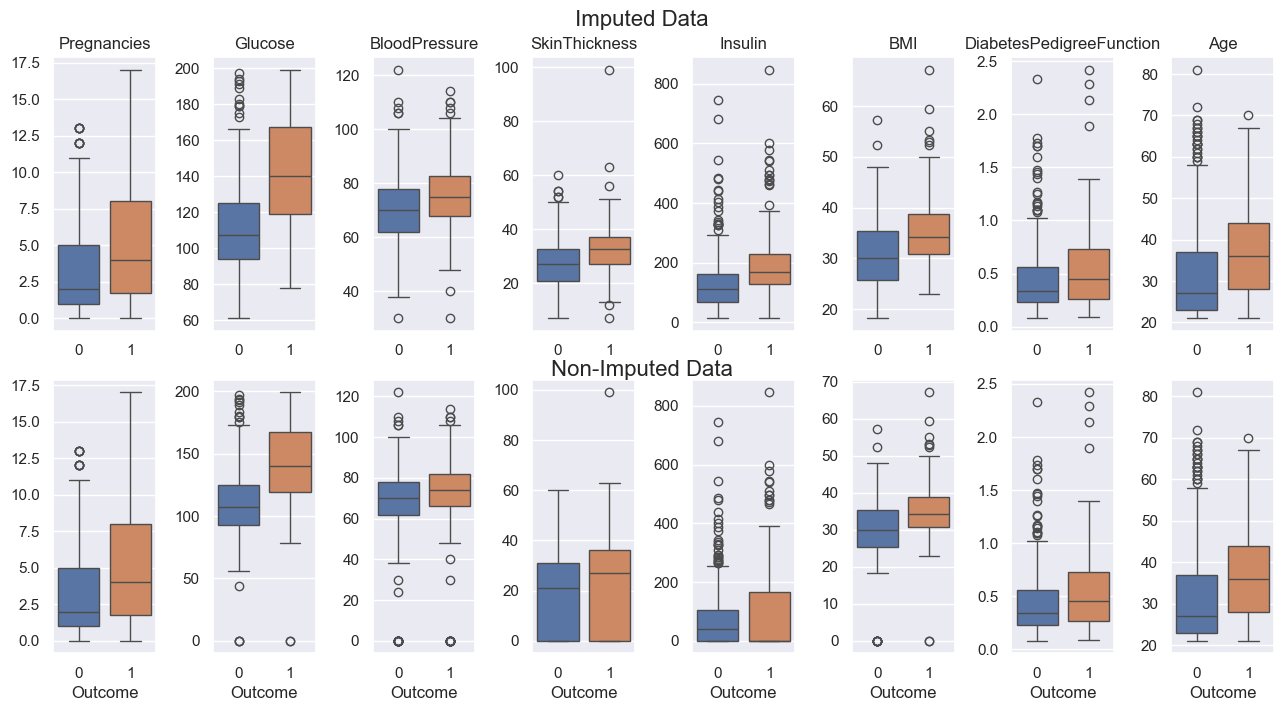

In [50]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(2, len(subset_columns), figsize=(13, 7))
for i, col in enumerate(subset_columns):
    sns.boxplot(
        x="Outcome",
        y=col,
        data=imputed_filled_missing_diabetes_df,
        ax=axes[0, i],
        hue="Outcome",
        legend=False,
    )
    axes[0, i].set_xlabel("")
    axes[0, i].set_ylabel("")
    axes[0, i].set_title(col)

    sns.boxplot(
        x="Outcome", y=col, data=diabetes_df, ax=axes[1, i], hue="Outcome", legend=False
    )
    axes[1, i].set_xlabel("Outcome")
    axes[1, i].set_ylabel("")
    axes[1, i].set_title("")

fig.text(0.5, 0.99, "Imputed Data", ha="center", fontsize=16)
fig.text(0.5, 0.49, "Non-Imputed Data", ha="center", fontsize=16)
plt.tight_layout()
plt.show()

When using imputed data, we can observe more distinct trends across the different outcomes. This is particularly noticeable in the `Insulin` feature, where the mean values for each outcome category have shifted in a positive direction. This shift indicates a more pronounced correlation among the independent variables and the outcome variable.

## Bivariate Analysis

### Correlation Analysis

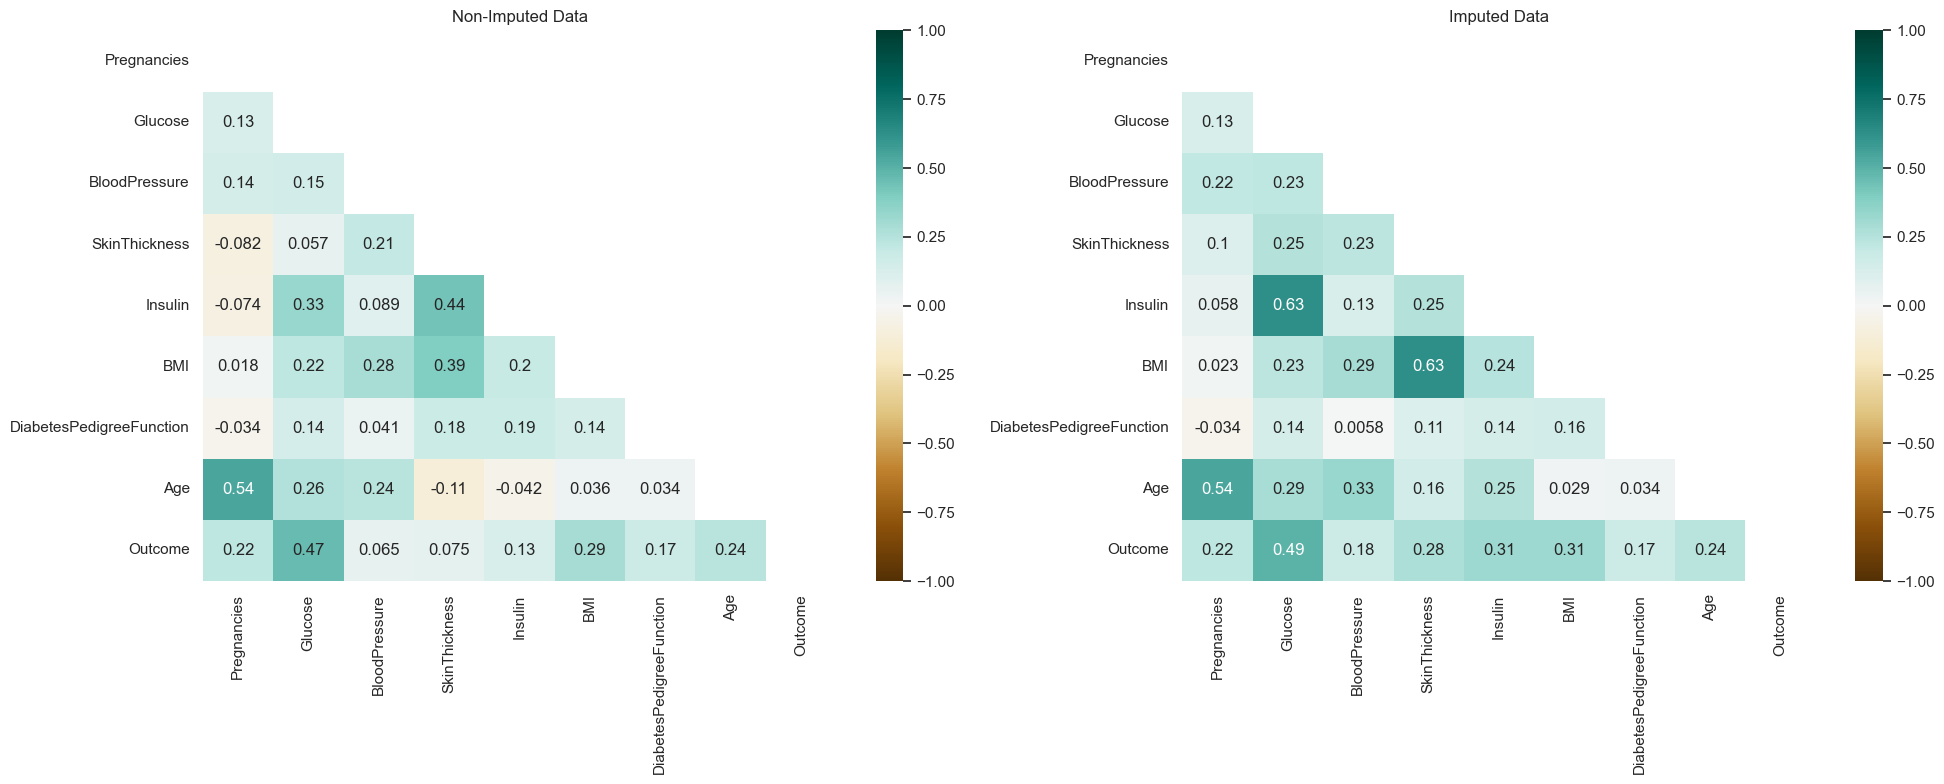

In [51]:
sns.set(style="whitegrid")
correlation_diabetes = diabetes_df.corr()
correlation_imputed_diabetes = imputed_filled_missing_diabetes_df.corr()
mask_diabetes = np.triu(np.ones_like(correlation_diabetes, dtype=bool))
mask_imputed_diabetes = np.triu(np.ones_like(correlation_imputed_diabetes, dtype=bool))
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(
    correlation_diabetes,
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="BrBG",
    mask=mask_diabetes,
    ax=axes[0],
)
axes[0].set_title("Non-Imputed Data")
axes[0].grid(False)
sns.heatmap(
    correlation_imputed_diabetes,
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="BrBG",
    mask=mask_imputed_diabetes,
    ax=axes[1],
)
axes[1].set_title("Imputed Data")
axes[1].grid(False)
plt.tight_layout()
plt.show()

We've introduced some correlation after imputing missing values. These are specifically around:
* Insulin and Glucose
* SkinThickness and BMI

### Transformations

We can transform our columns and introduce a new feature to tackle multi-collinearity.

#### Insulin and Glucose

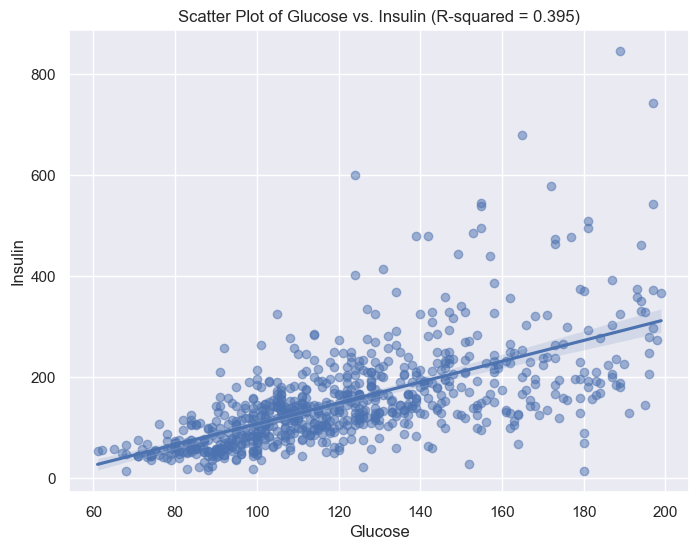

In [52]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=imputed_filled_missing_diabetes_df,
    x="Glucose",
    y="Insulin",
    scatter_kws={"alpha": 0.5},
)
correlation_matrix = np.corrcoef(
    imputed_filled_missing_diabetes_df["Glucose"],
    imputed_filled_missing_diabetes_df["Insulin"],
)
r_squared = correlation_matrix[0, 1] ** 2
plt.xlabel("Glucose")
plt.ylabel("Insulin")
plt.title(f"Scatter Plot of Glucose vs. Insulin (R-squared = {r_squared:.3f})")
plt.show()

* Given the moderately high $R^2$ and correlation coefficient, we'll transform these variables to create one variable - HOMA-IR.
* HOMA-IR stands for Homeostatic Model Assessment of Insulin Resistance [12], a method used to assess insulin resistance in the body.
* Calculated as `HOMA-IR = (Fasting Insulin (mu U/mL) × Fasting Glucose (mg/dL)) / 405`
* Lower HOMA-IR values typically indicate better insulin sensitivity, while higher values suggest insulin resistance.
* Lastly, we can't simply drop insulin and/or glucose because:
    *  In some cases of type 2 diabetes, individuals may have elevated glucose levels (indicating hyperglycemia) and insulin levels (indicating insulin resistance).
    *  In contrast, individuals with type 1 diabetes may have low insulin levels.

In [53]:
transformed_imputed_diabetes_df = imputed_filled_missing_diabetes_df.copy()

In [54]:
transformed_imputed_diabetes_df["HOMA-IR"] = (
    transformed_imputed_diabetes_df["Insulin"]
    * transformed_imputed_diabetes_df["Glucose"]
    / 405
)

In [55]:
transformed_imputed_diabetes_df[["HOMA-IR", "Outcome"]].corr()

,HOMA-IR,Outcome
HOMA-IR,1.000000,0.360967
Outcome,0.360967,1.000000


* Our correlation has significantly degraded, hence we won't be using `HOMA-IR` and use `Glucose` and `Insulin` instead.
* The trade-off for slightly lower multi-collinearity wouldn't be worthwhile.
* But let's confirm this once again after plotting Glucose against Insulin for each outcome variable.

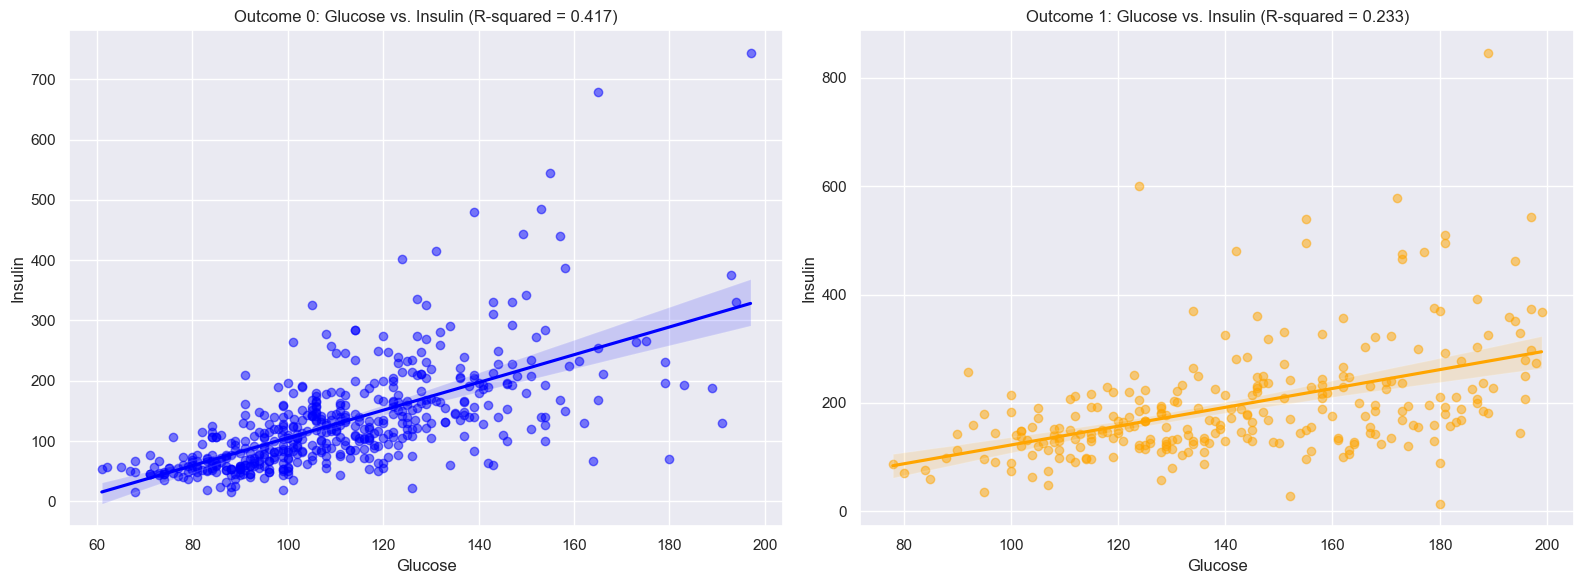

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
data_outcome_0 = imputed_filled_missing_diabetes_df[
    imputed_filled_missing_diabetes_df["Outcome"] == 0
]
data_outcome_1 = imputed_filled_missing_diabetes_df[
    imputed_filled_missing_diabetes_df["Outcome"] == 1
]

# Plot for Outcome = 0
sns.regplot(
    data=data_outcome_0,
    x="Glucose",
    y="Insulin",
    scatter_kws={"alpha": 0.5},
    ax=axes[0],
    color="blue",
)
correlation_matrix = np.corrcoef(data_outcome_0["Glucose"], data_outcome_0["Insulin"])
r_squared = correlation_matrix[0, 1] ** 2
axes[0].set_xlabel("Glucose")
axes[0].set_ylabel("Insulin")
axes[0].set_title(f"Outcome 0: Glucose vs. Insulin (R-squared = {r_squared:.3f})")

# Plot for Outcome = 1
sns.regplot(
    data=data_outcome_1,
    x="Glucose",
    y="Insulin",
    scatter_kws={"alpha": 0.5},
    ax=axes[1],
    color="orange",
)
correlation_matrix = np.corrcoef(data_outcome_1["Glucose"], data_outcome_1["Insulin"])
r_squared = correlation_matrix[0, 1] ** 2
axes[1].set_xlabel("Glucose")
axes[1].set_ylabel("Insulin")
axes[1].set_title(f"Outcome 1: Glucose vs. Insulin (R-squared = {r_squared:.3f})")
plt.tight_layout()
plt.show()

* The relationship among Glucose and Insulin is stronger for the Non-Diabetic patients
* The observation could be explained by non-diabetic individuals having more effective insulin sensitivity or producing insulin in response to glucose spikes.
* We will need to verify this with a domain expert. However, for now, we'll use our algorithm to train this.

#### SkinThickness and BMI

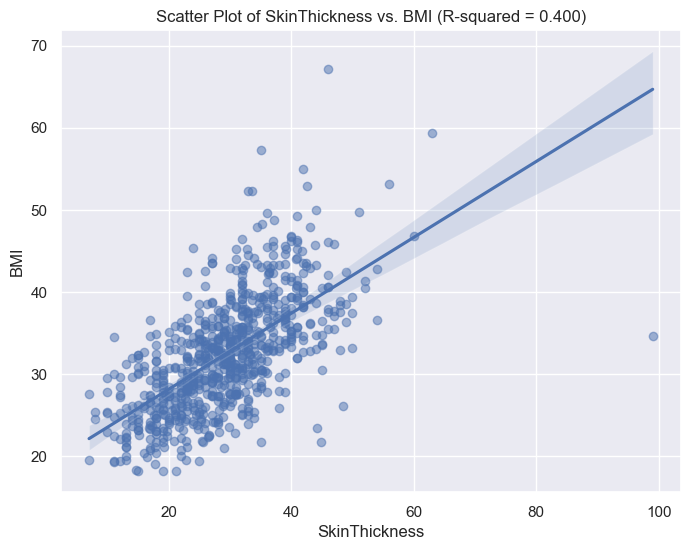

In [57]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.regplot(
    data=imputed_filled_missing_diabetes_df,
    x="SkinThickness",
    y="BMI",
    scatter_kws={"alpha": 0.5},
)
correlation_matrix = np.corrcoef(
    imputed_filled_missing_diabetes_df["SkinThickness"],
    imputed_filled_missing_diabetes_df["BMI"],
)
r_squared = correlation_matrix[0, 1] ** 2
plt.xlabel("SkinThickness")
plt.ylabel("BMI")
plt.title(f"Scatter Plot of SkinThickness vs. BMI (R-squared = {r_squared:.3f})")
plt.show()

* Although the $R^2$ and the correlation coefficient of `SkinThickness` and `BMI` are on the higher end, we shouldn't transform and combine them.
* These features may contain complementary information:
    * "BMI" provides a measure of overall body mass relative to height,
    * "SkinThickness" provides information about the distribution of subcutaneous fat.
* Furthermore, since there's no clinical metric to combine them, it would become hard to interpret a combination.
* We can verify this in comparison to the outcome variable.

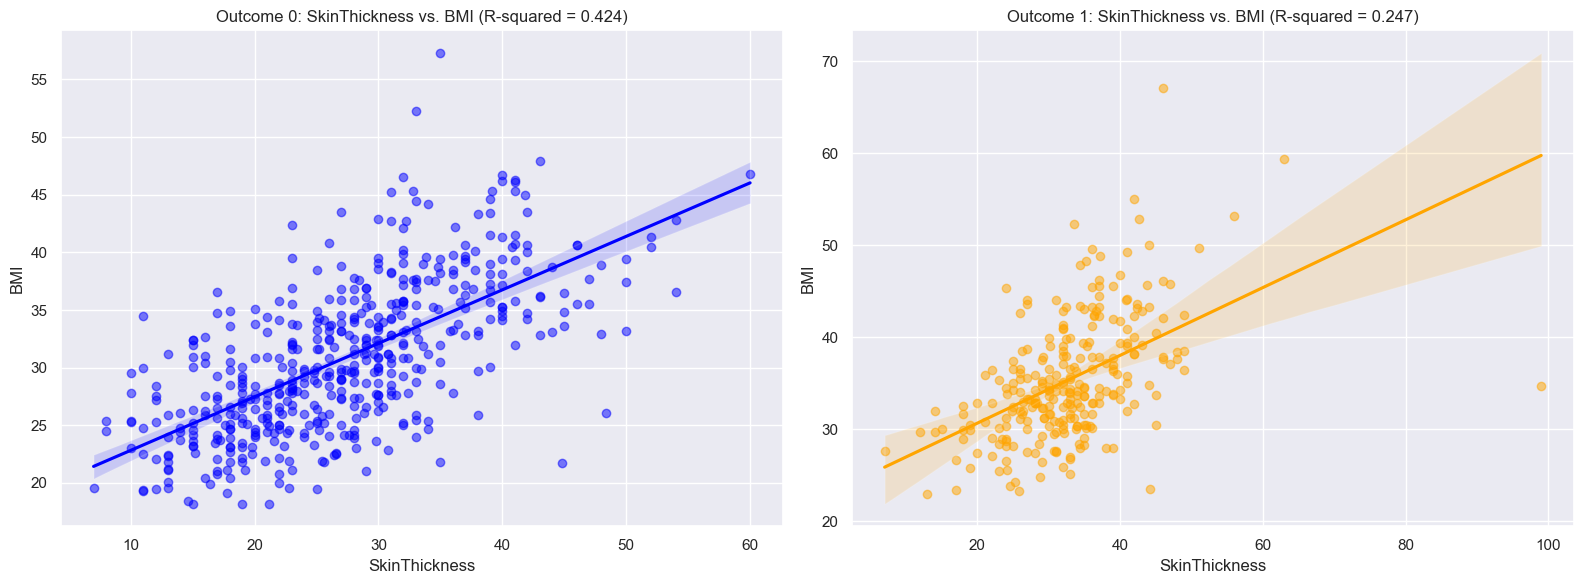

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
data_outcome_0 = imputed_filled_missing_diabetes_df[
    imputed_filled_missing_diabetes_df["Outcome"] == 0
]
data_outcome_1 = imputed_filled_missing_diabetes_df[
    imputed_filled_missing_diabetes_df["Outcome"] == 1
]

# Plot for Outcome = 0
sns.regplot(
    data=data_outcome_0,
    x="SkinThickness",
    y="BMI",
    scatter_kws={"alpha": 0.5},
    ax=axes[0],
    color="blue",
)
correlation_matrix = np.corrcoef(data_outcome_0["SkinThickness"], data_outcome_0["BMI"])
r_squared = correlation_matrix[0, 1] ** 2
axes[0].set_xlabel("SkinThickness")
axes[0].set_ylabel("BMI")
axes[0].set_title(f"Outcome 0: SkinThickness vs. BMI (R-squared = {r_squared:.3f})")

# Plot for Outcome = 1
sns.regplot(
    data=data_outcome_1,
    x="SkinThickness",
    y="BMI",
    scatter_kws={"alpha": 0.5},
    ax=axes[1],
    color="orange",
)
correlation_matrix = np.corrcoef(data_outcome_1["SkinThickness"], data_outcome_1["BMI"])
r_squared = correlation_matrix[0, 1] ** 2
axes[1].set_xlabel("SkinThickness")
axes[1].set_ylabel("BMI")
axes[1].set_title(f"Outcome 1: SkinThickness vs. BMI (R-squared = {r_squared:.3f})")
plt.tight_layout()
plt.show()

* Similar to _Glucose vs. Insulin_, the $R^2$ is higher for non-diabetic patients.
* There could be other confounding factors at play. For instance, the presence of other comorbidities is why we see a weaker trend for _Glucose vs. Insulin_ and _BMI vs. SkinThickness_.
* There could also be other subgroups of diabetics, such as Type 1 and Type 2, and each group could exhibit more heterogeneity.
* Our immutation strategy might not work well for Diabetic patients, which could be one possible explanation. However, the data is missing at random concerning the outcome variable.
* Medical advice is necessary here.

#### Age buckets

* Binning or discretizing the "Age" feature would help us reduce data sparsity.
* Certain bin intervals may correspond to a higher onset of diabetes.

In [59]:
max_age = 100
interval = 9

bin_edges = list(range(18, max_age + 1, interval))
bin_labels = [f"{start}-{start + interval - 1}" for start in bin_edges[:-1]]

transformed_imputed_diabetes_df["AgeGroup"] = pd.cut(
    transformed_imputed_diabetes_df["Age"],
    bins=bin_edges,
    labels=bin_labels,
    right=False,
)

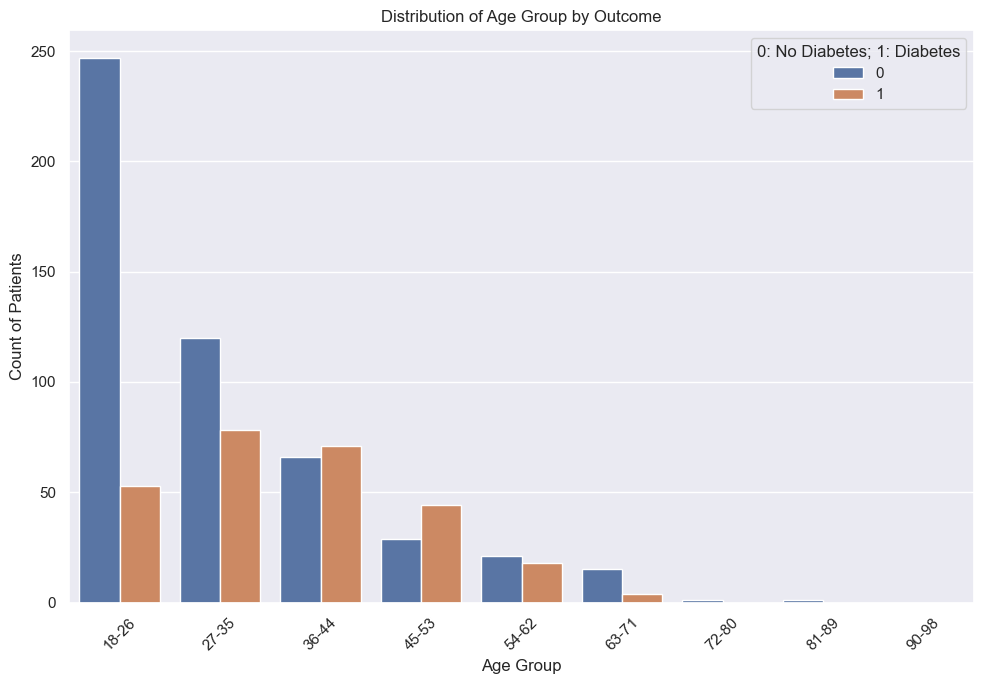

In [60]:
plt.figure(figsize=(10, 7))
sns.countplot(x="AgeGroup", hue="Outcome", data=transformed_imputed_diabetes_df)
plt.xlabel("Age Group")
plt.ylabel("Count of Patients")
plt.title("Distribution of Age Group by Outcome")
plt.xticks(rotation=45)
plt.legend(title="0: No Diabetes; 1: Diabetes")
plt.tight_layout()
plt.show()

The above plot illustrates that a younger age group has a significantly lower likelihood of experiencing diabetes. As age increases within the dataset, there is a gradual rise in the risk of diabetes.

In [61]:
transformed_imputed_diabetes_df.drop(
    [
        "Age",
    ],
    axis=1,
    inplace=True,
)

## Scaling and One-Hot Encoding

* Scaling helps logistic regression converge faster and ensures that all features have equal importance.
* We'll use standard scaling over minmax as it makes our model less sensitive to outliers.
* Since we imputed our data to resemble a Gaussian distribution, Standard scaling would be better applicable.

In [62]:
standard_scaling_columns = [
    "Pregnancies",
    "BloodPressure",
    "SkinThickness",
    "BMI",
    "DiabetesPedigreeFunction",
    "Insulin",
    "Glucose",
]

In [63]:
standard_scaler = StandardScaler()
scaled_transformed_imputed_diabetes_df = transformed_imputed_diabetes_df.copy()
scaled_transformed_imputed_diabetes_df[
    standard_scaling_columns
] = standard_scaler.fit_transform(
    scaled_transformed_imputed_diabetes_df[standard_scaling_columns]
)

One-Hot Encoding our data.

In [64]:
scaled_transformed_imputed_diabetes_df = pd.get_dummies(
    scaled_transformed_imputed_diabetes_df, columns=["AgeGroup"], dtype=int
)

## Model

In [65]:
diabetes_cm_cf = ConfusionMatrixDisplay(diabetes_cm)

new_diabetes_cm = score_data(scaled_transformed_imputed_diabetes_df)
new_diabetes_cm_cf = ConfusionMatrixDisplay(new_diabetes_cm)

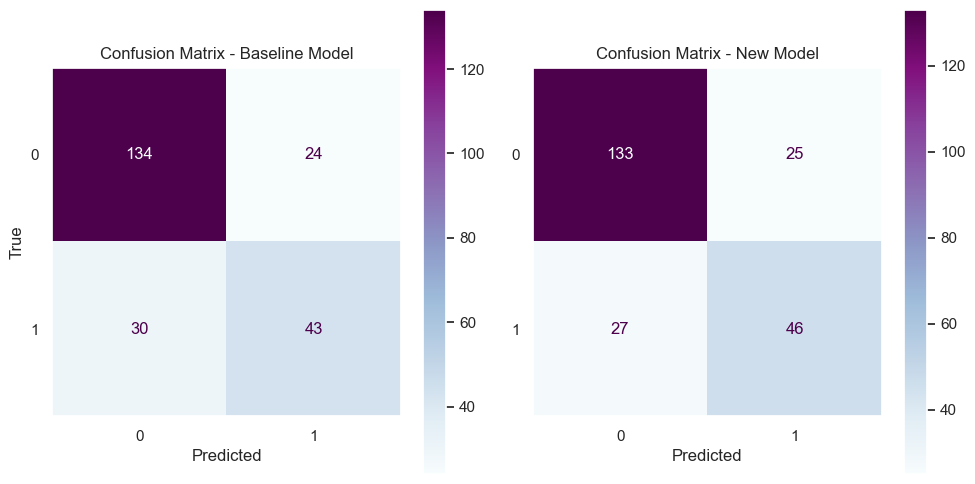

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

diabetes_cm_cf.plot(ax=axes[0], cmap="BuPu")
new_diabetes_cm_cf.plot(ax=axes[1], cmap="BuPu")

axes[0].set_title("Confusion Matrix - Baseline Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

axes[1].set_title("Confusion Matrix - New Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

axes[0].grid(False)
axes[1].grid(False)
plt.tight_layout()
plt.show()

In [67]:
# True positive, false positive, true negative, false negative
tp = new_diabetes_cm[1, 1]
fp = new_diabetes_cm[0, 1]
tn = new_diabetes_cm[0, 0]
fn = new_diabetes_cm[1, 0]

# Calculating Scores
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)  # also, sensitivity
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.77
Precision: 0.65
Recall (Sensitivity): 0.63
Specificity: 0.84
F1 Score: 0.64


We can interpret the metrics compared to the baseline logistic regression algorithm as follows:

1. Accuracy (0.77 $\rightarrow$ 0.77):
   - Our overall accuracy has remained the same.
   - Indicating our model is still correctly predicting diabetes and non-diabetes cases at a similar rate as the baseline.
2. Precision (0.64 $\rightarrow$ 0.65):
   - Our precision has improved by 0.01.
   - Our new model is a bit more reliable when making positive predictions.
   - Although the number of False Positives has increased, we've also improved our True Positive, which overall improved our recall.
3. Recall/Sensitivity (0.59 $\rightarrow$ 0.63):
   - Our model's recall has improved significantly (by 0.04).
   - Our model is becoming more sensitive and capable of capturing a larger portion of the actual positive cases.
4. Specificity (0.85 $\rightarrow$ 0.84):
   - Our model is slightly more prone to making false positive predictions.
   - A lower specificity value indicates the model misled the negative results as positive.
5. F1 Score (0.61 $\rightarrow$ 0.64):
   - We haven't sacrificed an improved sensitivity for a lower precision.
   - Indicating that our model achieves a better balance between precision and recall.
  
* In the context of diabetes prediction, the primary concern is often to identify individuals who actually have diabetes (True Positives).
* Missing a true diabetic case (False Negatives) could lead to untreated diabetes, which can have severe health implications.
* However, this is at the risk of unnecessary follow-up tests or medical examinations.

## Leakage Assessment

* Using the entire dataset for EDA:
    * We have performed EDA on the entire dataset, including the training and test data.
    * EDA should ideally be done on the training data alone while ensuring the test set is untouched.
    * We have made decisions based on characteristics in the test set, which could lead to an over-optimistic assessment of model performance (and lower generalizing ability).
* Biased model evaluation:
    * We have delayed separating the training and test data until the model evaluation step.
    * We're exposing the model to prematurely testing data through our EDA.
* Feature Engineering on the entire dataset:
    * The Scaled Values, Encodings, and missing data imputations all contain data we've used in our test set.
    * We have inadvertently captured patterns in the test data, undermining the model's generalization performance.
    * These transformations should have been applied separately to the training and test datasets after the split to ensure that the test data remains independent and representative of unseen data.
* Target Leakage:
    *  During our EDA, we've inadvertently introduced some instances of target leakage, particularly in our bivariate and missing data analysis.
    *  When examining missing data patterns, we may have considered the relationship between missing values and the target variable. This can introduce bias into our analysis as we inadvertently link the missingness of data to the outcome.
    *  However, we haven't used the target variable to impute our missing data, which would have severely hampered our model's generalizing ability.
* Ideal Pipeline:
    * We should be splitting our dataset into three distinct sets: training, validation, and test sets.
    * The training set is used to train the model, the validation set is used for model tuning and hyperparameter optimization, and the test set is reserved for final model evaluation.
    * Furthermore, any EDA we perform should be done on the training set, and the test set is only supposed to be used once for final evaluation.

## References

1. [CDC - Gestational Diabetes](https://www.cdc.gov/diabetes/basics/gestational.html)
2. [Ro.co - The oral glucose tolerance test (OGTT) explained](https://ro.co/health-guide/oral-glucose-tolerance-test-ogtt/#what-are-the-advantages-and-disadvantages-of-the-oral-glucose-tolerance-test)
3. [CDC - Diabetes Test](https://www.cdc.gov/diabetes/basics/getting-tested.html)
4. [NCBI - Hypoglycemia, functional brain failure, and brain death](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1838950/)
5. [Michaels Miracles - World record for glucose level](https://www.michaelsmiracles.net/2011.html)
6. [Heart.org - Blood Pressure Readings](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings)
7. [Pubmed - Influence of breathing technique on arterial blood pressure during heavy weight lifting](https://pubmed.ncbi.nlm.nih.gov/7741618/)
8. [Pubmed - Low insulin sensitivity (S(i) = 0) in diabetic and nondiabetic subjects in the insulin resistance atherosclerosis study](https://pubmed.ncbi.nlm.nih.gov/14514582/)
9. [American Diabetes Association - Genetics of Diabetes](https://diabetes.org/about-diabetes/genetics-diabetes)
10. [American Diabetes Association - Diabetes in Older Adults](https://diabetesjournals.org/care/article/35/12/2650/38582/Diabetes-in-Older-Adults)
11. [American Diabetes Association - Effects of Traditional and Western Environments on Prevalence of Type 2 Diabetes in Pima Indians in Mexico and the U.S.](https://diabetesjournals.org/care/article/29/8/1866/28611/Effects-of-Traditional-and-Western-Environments-on)
12. [American Journal of Gastroenterology - HOMA-IR](https://journals.lww.com/ajg/fulltext/2009/10003/accuracy_of_homa_ir_in_clinical_practice__342.342.aspx)